In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
import os

In [2]:
#specify the learning rate
learning_rate = 0.0005

curr_dir = os.getcwd()
print(curr_dir)


# Load Dataset
df = pd.read_csv('MedData.csv')

c:\Users\nnaji\OneDrive\Documents\GitHub\UGRA_LSTM_Solar-Prediction\Homework2_baseline


In [3]:
# Separate Prediction Variable
solar_Xdata = df.copy()
solar_ydata = solar_Xdata.pop("POWER")
solar_Xdata = df.copy()

# Reshape Data
solar_Xdata = solar_Xdata.values.reshape(-1,solar_Xdata.shape[1])
solar_ydata = solar_ydata.values.reshape(-1,1)

In [4]:
# Normalize Data
scaler = MinMaxScaler()
solar_XdataN = scaler.fit_transform(solar_Xdata)
solar_ydataN = scaler.fit_transform(solar_ydata)

In [5]:
# Create Sequences
X, y = [], []
for i in range(24, len(solar_ydataN)):
    X.append(solar_XdataN[i-24:i,0]) #This is the selected feautres that are going to be used. 
    y.append(solar_ydataN[i, 0])
X, y = np.array(X), np.array(y)

# Split data into training and testing sets
train_size = int(0.8 * len(y))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM layer
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))


In [6]:
# Build LSTM Model
solar_model = Sequential()
solar_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1)))
solar_model.add(LSTM(units = 50))
solar_model.add(Dense(units=1))

# Create Model
# set Epoch number
setEpoch = 50

# create the optimizer with the desired learning rate
adam_optimizer = Adam(lr = learning_rate)
solar_model.compile(optimizer=adam_optimizer, loss='mean_absolute_error')
solar_model.fit(X_train, y_train, epochs = setEpoch, batch_size = 32)

Epoch 1/50
438/438 [==============================] - 13s 19ms/step - loss: 0.1774
Epoch 2/50
438/438 [==============================] - 8s 19ms/step - loss: 0.1312
Epoch 3/50
438/438 [==============================] - 11s 24ms/step - loss: 0.1134
Epoch 4/50
438/438 [==============================] - 7s 16ms/step - loss: 0.0949
Epoch 5/50
438/438 [==============================] - 7s 16ms/step - loss: 0.0865
Epoch 6/50
438/438 [==============================] - 7s 17ms/step - loss: 0.0827
Epoch 7/50
438/438 [==============================] - 8s 18ms/step - loss: 0.0796
Epoch 8/50
438/438 [==============================] - 7s 17ms/step - loss: 0.0764
Epoch 9/50
438/438 [==============================] - 7s 17ms/step - loss: 0.0743
Epoch 10/50
438/438 [==============================] - 7s 17ms/step - loss: 0.0724
Epoch 11/50
438/438 [==============================] - 8s 17ms/step - loss: 0.0712
Epoch 12/50
438/438 [==============================] - 8s 17ms/step - loss: 0.0686
Epoch 13/50

110/110 [==============================] - 2s 6ms/step


Text(0.02, 0.5, 'DC Power [MW]')

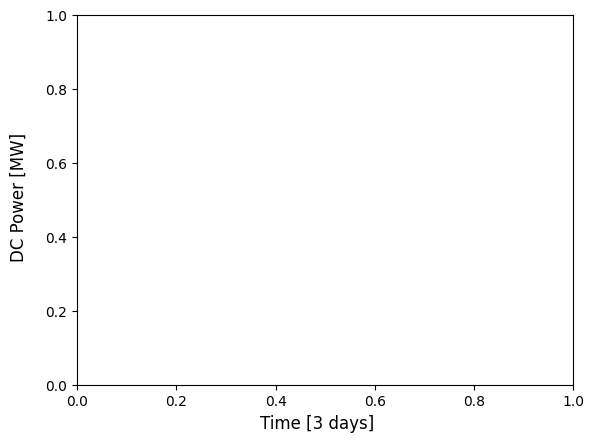

In [7]:
# Run Prediction
y_pred = solar_model.predict(X_test)
y_pred_orig = scaler.inverse_transform(y_pred)
y_test_orig = scaler.inverse_transform(y_test.reshape(-1,1))

# Display / Graph
# Figure labels
fig, axs = plt.subplots()
fig.supxlabel("Time [3 days]")
fig.supylabel("DC Power [MW]")

In [8]:
# Evaluate Error
mae = mean_absolute_error(y_test_orig, y_pred_orig)

# Display
axs.plot(y_test_orig[0:150])
axs.plot(y_pred_orig[0:150])

# Title Graph with Epochs and Error
title = "Train From " + str(solar_Xdata.shape[1]) + " Inputs\n" + "Epochs: " + str(setEpoch) + ". Avg MAE Error: " + str(f"{mae:.2f}")
fig.suptitle(title)

# Save Graph as PNG
filename = "Inputs_" + str(solar_Xdata.shape[1]) + "_Epochs_" + str(setEpoch)
filepath = 'Images/'
plt.savefig(curr_dir + "\\" +filename)
plt.show()


<Figure size 640x480 with 0 Axes>